In [ ]:
!pip install pytorch-lightning

# VGG16

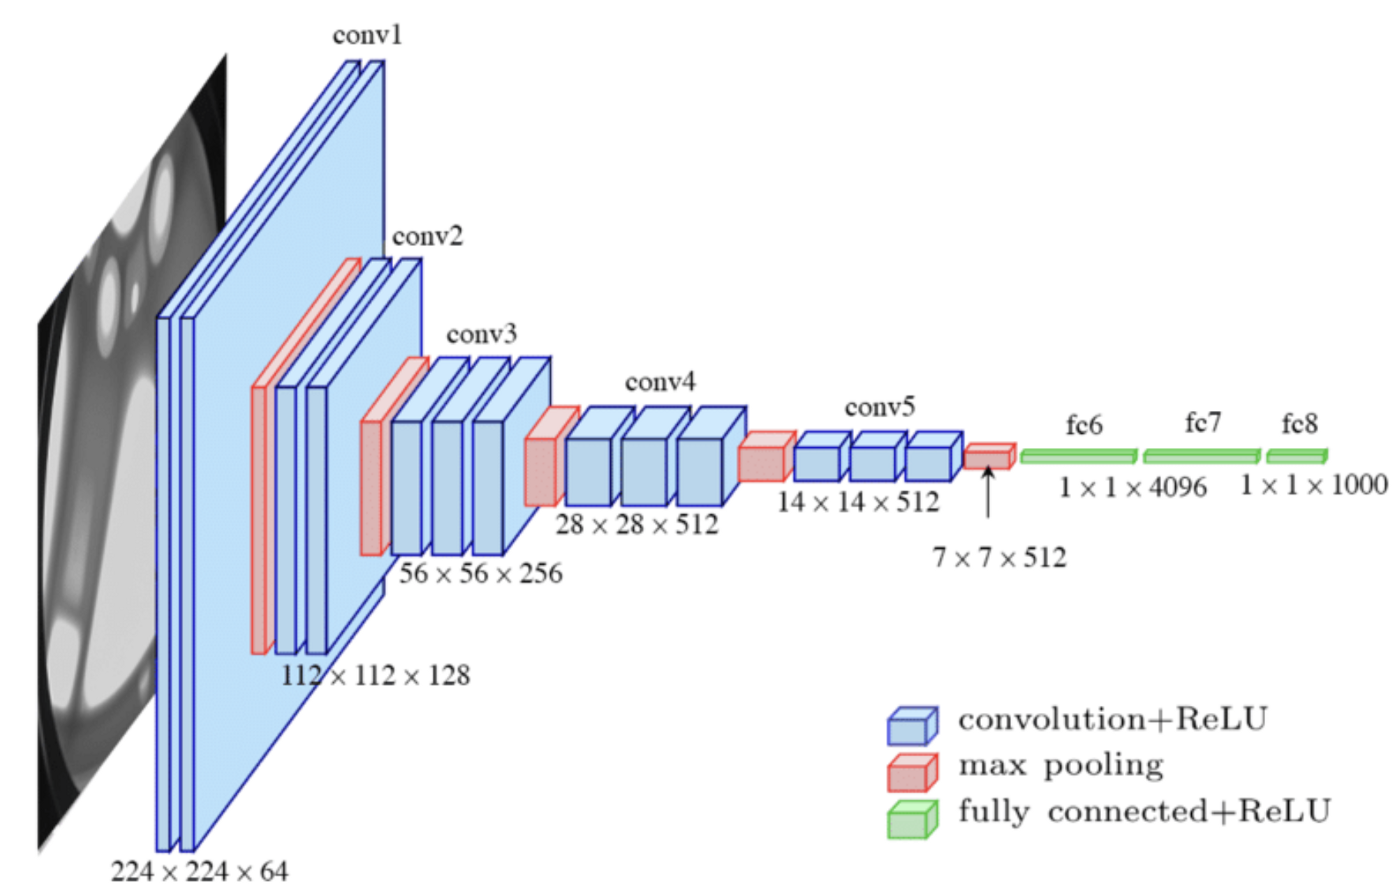

In [ ]:
import pytorch_lightning as pl
from torch import nn
import torchmetrics
import torch.nn.functional as F
from torch import optim

In [ ]:
class VGG16(pl.LightningModule):
  def __init__(self, num_classes):
    super().__init__()
    
    super(VGG16, self).__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

    self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

    self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
    self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

    self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(25088, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 10)

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')

  def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.maxpool(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.maxpool(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.maxpool(x)
      x = F.relu(self.conv4_1(x))
      x = F.relu(self.conv4_2(x))
      x = F.relu(self.conv4_3(x))
      x = self.maxpool(x)
      x = F.relu(self.conv5_1(x))
      x = F.relu(self.conv5_2(x))
      x = F.relu(self.conv5_3(x))
      x = self.maxpool(x)
      x = x.reshape(x.shape[0], -1)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, 0.5) 
      x = F.relu(self.fc2(x))
      x = F.dropout(x, 0.5)
      x = self.fc3(x)
      return x

  def configure_optimizers(self):
    optimizer =  optim.SGD(self.parameters(), lr = 0.01)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float()) 
    loss = self.loss_function(outputs, labels) 

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch 


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

# Inception

In [ ]:
import torch

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_chanels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_chanels, **kwargs)
        self.bn = nn.BatchNorm2d(out_chanels)
        
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

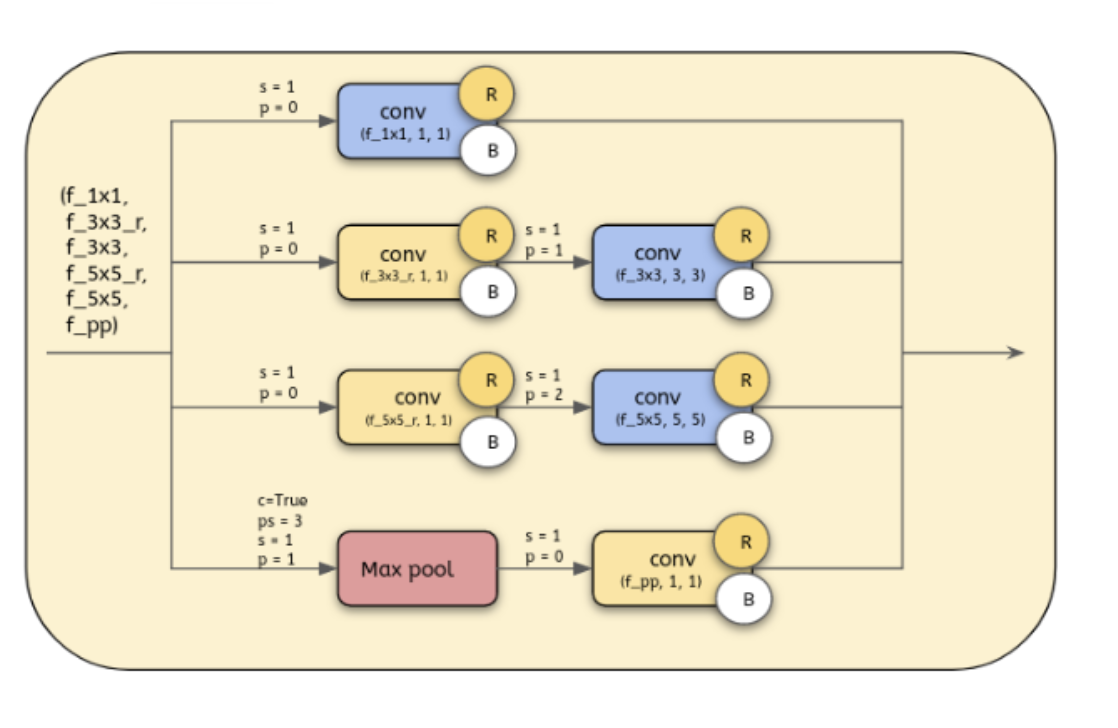

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5,
        out_pool,
    ):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1, padding=0),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )
    
    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)

In [ ]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class InceptionV1(pl.LightningModule):
  def __init__(self, aux_logits=True, num_classes=1000):
    super(InceptionV1, self).__init__()
    self.aux_logits = aux_logits
    self.conv1 = ConvBlock(
        in_channels=3, 
        out_chanels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
    )
    self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
    self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
    self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc = nn.Linear(1024, num_classes)
    
    if self.aux_logits:
        self.aux1 = InceptionAux(512, num_classes)
        self.aux2 = InceptionAux(528, num_classes)
    else:
        self.aux1 = self.aux2 = None

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')

  def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        
        if self.aux_logits and self.training: 
            aux1 = self.aux1(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        
        if self.aux_logits and self.training: 
            aux2 = self.aux2(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        if self.aux_logits and self.training: 
            return aux1, aux2, x
        return x

  def configure_optimizers(self):
    optimizer =  optim.SGD(self.parameters(), lr = 0.01)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    aux1, aux2, outputs = self.forward(inputs.float()) 
    
    aux1_loss = self.loss_function(aux1, labels) 
    aux2_loss = self.loss_function(aux2, labels) 
    output_loss = self.loss_function(outputs, labels) 

    loss = aux1_loss + aux2_loss + output_loss

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch 


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

# ResNet

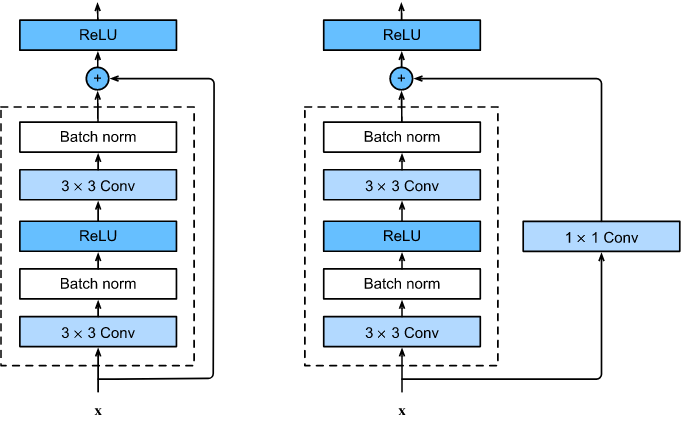

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class InceptionV1(pl.LightningModule):
  def __init__(self, in_channels, resblock, outputs=1000):
    super().__init__()
    self.layer0 = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ) 

    self.layer1 = nn.Sequential(
        resblock(64, 64, downsample=False),
        resblock(64, 64, downsample=False)
    )

    self.layer2 = nn.Sequential(
        resblock(64, 128, downsample=True),
        resblock(128, 128, downsample=False)
    )

    self.layer3 = nn.Sequential(
        resblock(128, 256, downsample=True),
        resblock(256, 256, downsample=False)
    )


    self.layer4 = nn.Sequential(
        resblock(256, 512, downsample=True),
        resblock(512, 512, downsample=False)
    )

    self.gap = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(512, outputs)

  def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x)
        x = self.fc(x)

        return x

  def configure_optimizers(self):
    optimizer =  optim.SGD(self.parameters(), lr = 0.01)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float()) 
    loss = self.loss_function(outputs, labels) 

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch 


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [ ]:
from google.colab import drive
!pip3 install --upgrade gdown

In [ ]:
!gdown 1WKDTw02e504JR5gPBjECQEFWLCLehGaa

Downloading...
From: https://drive.google.com/uc?id=1WKDTw02e504JR5gPBjECQEFWLCLehGaa
To: /content/archive.zip
 16% 101M/614M [00:22<01:55, 4.46MB/s]


In [ ]:
!unzip archive.zip

Archive:  archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of archive.zip or
        archive.zip.zip, and cannot find archive.zip.ZIP, period.


## Wczytywanie danych

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision import transforms 

In [ ]:
class AnimalsDatamodule(pl.LightningDataModule):
  def __init__(self, batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
  def setup(self, stage = None):
    transform = transforms.Compose([
                                    transforms.CenterCrop(200),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0), (1))
                                ])
    
    dataset = ImageFolder(root='raw-img/', transform=transform)
    print(len(dataset))
    self.train_dataset, self.test_dataset = random_split(dataset, [len(dataset)- len(dataset)//4, len(dataset)//4])


  def train_dataloader(self):
    return  DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
  def val_dataloader(self):
    return  DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [ ]:
dm = AnimalsDatamodule()
dm.setup()

FileNotFoundError: ignored

In [ ]:
import torchvision.models as models

In [ ]:
model = models.vgg16(pretrained=True)
print(model)

In [ ]:
class AnimalsModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.backbone = model.features
    self.pooling = model.avgpool

    self.fc1 = nn.LazyLinear(500) 
    self.fc2 = nn.LazyLinear(10) 

    self.loss_function = nn.CrossEntropyLoss()

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    self.train_macro_f1 = torchmetrics.F1Score(num_classes=10, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(num_classes=10, average='macro')

    for param in self.backbone.parameters():
      param.requires_grad = False

    for param in self.pooling():
      param.requires_grad = False

  def forward(self, x):
      self.backbone.eval()  
      x = self.backbone(x)
      x = self.pooling(x).flatten(1)

      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      return x

  def configure_optimizers(self):
    optimizer =  optim.Adam(self.parameters(), lr = 0.0001)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float()) 
    loss = self.loss_function(outputs, labels) 

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch 


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

In [ ]:
model = AnimalsModel()

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="model")

In [ ]:
trainer = pl.Trainer(gpus=1, logger = logger, max_epochs = 15, log_every_n_steps =1)

In [ ]:
trainer.fit(model, dm)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
model = models.resnet101(pretrained=True)
print(model)

In [ ]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x

In [ ]:
model.fc = Identity()

In [ ]:
class AnimalsModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.backbone = model
    self.fc1 = nn.LazyLinear(500)
    self.fc2 = nn.LazyLinear(10)

    self.loss_function = nn.CrossEntropyLoss()


    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    self.train_macro_f1 = torchmetrics.F1Score(num_classes=10, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(num_classes=10, average='macro')

    for param in self.backbone.parameters():
      param.requires_grad = False

  def forward(self, x):
      self.backbone.eval()
      
      x = self.backbone(x)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      return x

  def configure_optimizers(self):
    optimizer =  optim.Adam(self.parameters(), lr = 0.0001)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float()) 
    loss = self.loss_function(outputs, labels) 

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch 


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

In [ ]:
from copy import copy
from torch.utils.data import Dataset

In [ ]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform# TODO

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = subset(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
class AnimalsAugmentedDatamodule(pl.LightningDataModule):
  def __init__(self, batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
  def setup(self, stage = None):
    train_transform = transforms.Compose([
                      transforms.CenterCrop(200),
                      transforms.RandomVerticalFlip(p=0.5),
                      transforms.RandomRotation(30, p=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((0),(1))
                      ])
    
    test_transform = transforms.Compose([
                      transforms.CenterCrop(200),
                      transforms.ToTensor(),
                      transforms.Normalize((0),(1))
                      ])
    
    dataset = ImageFolder(root='raw-img/')
    self.train_dataset, self.test_dataset = random_split(dataset, [ len(dataset)- len(dataset)//4, len(dataset)//4])

    self.train_dataset = DatasetFromSubset(self.train_dataset, transform = train_transform)
    self.test_dataset = DatasetFromSubset(self.test_dataset, transform = test_transform)


  def train_dataloader(self):
    return  DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
  def val_dataloader(self):
    return  DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [ ]:
dm = AnimalsAugmentedDatamodule()

In [ ]:
dm.setup()

In [ ]:
image = dm.train_dataset[2][0]

In [ ]:
image = image.permute(1, 2, 0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(image)